#PCA-32

#Architecture 1024,256,64

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Flatten)        (None, 784)               0         
                                                                 
 Hlayer1 (Dense)             (None, 1024)              803840    
                                                                 
 Hlayer2 (Dense)             (None, 256)               262400    
                                                                 
 Hlayer3 (Dense)             (None, 64)                16448     
                                                                 
 output (Dense)              (None, 5)                 325       
                                                                 
Total params: 1,083,013
Trainable params: 1,083,013
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
356/356 [=======================

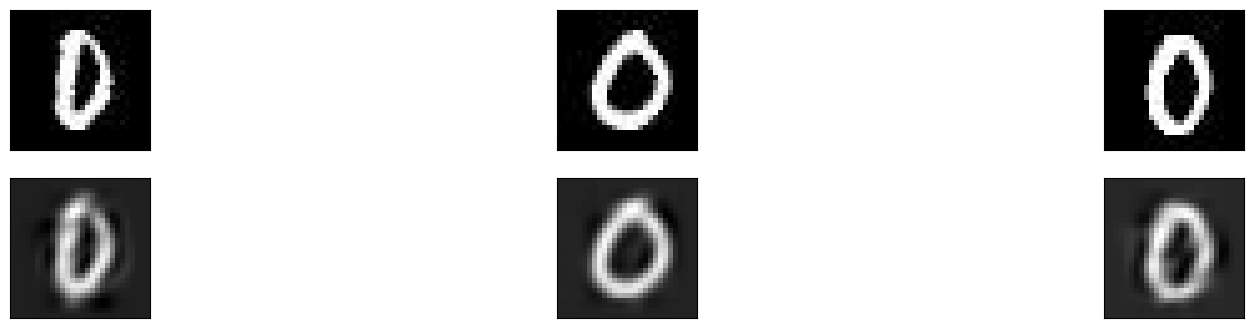

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os,sys
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import initializers
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import pickle as p
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 




initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=100)
#print('Initializer: ',initializer)

def Upload_Dataset(Dataset_Path):
    
    Path_train_Dataset = Dataset_Path+"/train"
    Path_test_Dataset = Dataset_Path+"/test"
    Path_val_Dataset = Dataset_Path+"/val"
    
    Input_train_Dataset, Input_test_Dataset, Input_val_Dataset = [], [], []
    Output_train, Output_test, Output_val = [], [], []

    for j in os.listdir(Path_train_Dataset):

        if j != ".DS_Store":
            for k in os.listdir(Path_train_Dataset+"/"+j):
                Input_train_Dataset.append(cv2.imread(Path_train_Dataset+"/"+j+"/"+k, cv2.IMREAD_GRAYSCALE))
                if(j == '6'):
                    Output_train.append(int(2))
                elif(j == '7'):
                    Output_train.append(int(3))
                elif(j == '9'):
                    Output_train.append(int(4))
                else:
                    Output_train.append(int(j))

            for k in os.listdir(Path_test_Dataset+"/"+j):
                Input_test_Dataset.append(cv2.imread(Path_test_Dataset+"/"+j+"/"+k, cv2.IMREAD_GRAYSCALE))
                if(j=='6'):
                    Output_test.append(int(2))
                elif(j=='7'):
                    Output_test.append(int(3))
                elif(j=='9'):
                    Output_test.append(int(4))
                else:
                    Output_test.append(int(j))

            for k in os.listdir(Path_val_Dataset+"/"+j):
                Input_val_Dataset.append(cv2.imread(Path_val_Dataset+"/"+j+"/"+k, cv2.IMREAD_GRAYSCALE))
                if(j=='6'):
                    Output_val.append(int(2))
                elif(j=='7'):
                    Output_val.append(int(3))
                elif(j=='9'):
                    Output_val.append(int(4))
                else:
                    Output_val.append(int(j))
        
    #print(Output_train)            
    Input_train_Dataset, Input_test_Dataset, Input_val_Dataset = np.array(Input_train_Dataset), np.array(Input_test_Dataset), np.array(Input_val_Dataset)
    #Output_train, Output_test, Output_val = np.array(list(map(int, Output_train))), np.array(list(map(int, Output_test))), np.array(list(map(int, Output_val)))
    Output_train, Output_test, Output_val = np.array(Output_train), np.array(Output_test), np.array(Output_val)
    #print(Output_train) 
    return Input_train_Dataset, Input_test_Dataset,Input_val_Dataset, Output_train, Output_test, Output_val



#providing path of  MNIST dataset
Dataset_Path = "/content/drive/MyDrive/Group_1"


#calling Upload_Dataset function
Input_train_Dataset, Input_test_Dataset,Input_val_Dataset, Output_train, Output_test, Output_val= Upload_Dataset(Dataset_Path)
#print(Input_train_Dataset.shape,'\n')
xTrain=np.reshape(Input_train_Dataset,(Input_train_Dataset.shape[0],784))
pca3=PCA(32)#based on arch
pca3.fit(xTrain)
pcaTrain3=pca3.transform(xTrain)
pcaTrainrecons3=pca3.inverse_transform(pcaTrain3).reshape(Input_train_Dataset.shape[0],28,28)
'''
n=3

plt.figure(figsize=(20,4))
for i in range(n):
    #displaying original image
    ax=plt.subplot(2,n,i+1)
    plt.imshow(xTrain[i].reshape(28,28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #displaying reconstructed image
    ax=plt.subplot(2,n,i+1+n)
    plt.imshow(pcaTrainrecons4[i].reshape(28,28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
'''

model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28), name='InputLayer'),
        layers.Dense(1024, activation="sigmoid", name="Hlayer1",kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(256, activation="sigmoid", name="Hlayer2",kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(64, activation="sigmoid", name="Hlayer3",kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(5, activation="softmax", name="output"),
        ])
model.summary()

adam =Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8,name='Adam')


model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='loss',min_delta=0.0001, patience=10,verbose=1)

model_fit = model.fit(x = pcaTrainrecons3, y = Output_train, batch_size = 32, epochs = 10000, verbose = "auto", callbacks=[es], validation_data=(Input_val_Dataset,  Output_val), validation_batch_size=1)
model.save('/content/drive/MyDrive/DLA4/pca3_128.h5')
f=open('/content/drive/MyDrive/DLA4/Histpca3_32.pckl','wb')
p.dump(model_fit.history,f)
f.close()


print('\nEvaluation of model on train data:')
trainAcc=model.evaluate(x=pcaTrainrecons3,y=Output_train,batch_size=1, verbose="auto",callbacks=None)
print(model.metrics_names)
print(trainAcc)

print('\nEvaluation of model on validation data:')
valAcc=model.evaluate(x=Input_val_Dataset, y=Output_val, batch_size=1, verbose="auto",callbacks=None)
print(model.metrics_names)
print(valAcc)

print('\nEvaluation of model on test data:')
testAcc=model.evaluate(x=Input_test_Dataset, y=Output_test, batch_size=1, verbose="auto",callbacks=None)
print(model.metrics_names)
print(testAcc)

print('\nPredictions for test data:')
testProb=model.predict(Input_test_Dataset, batch_size=1, verbose="auto", callbacks=None)
pred=np.argmax(testProb,axis=1)
print(pred)

#confusionMatrix=confusion_matrix(Output_test, pred)
confusionMatrix=confusion_matrix(Output_test,pred)
#confusionMatrix=tf.math.confusion_matrix(Output_test, pred5)
print(confusionMatrix)

n=3
plt.figure(figsize=(20,4))
for i in range(n):
    #displaying original image
    ax=plt.subplot(2,n,i+1)
    plt.imshow(xTrain[i].reshape(28,28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #displaying reconstructed image
    ax=plt.subplot(2,n,i+1+n)
    plt.imshow(pcaTrainrecons3[i].reshape(28,28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

